<IPython.core.display.Javascript object>


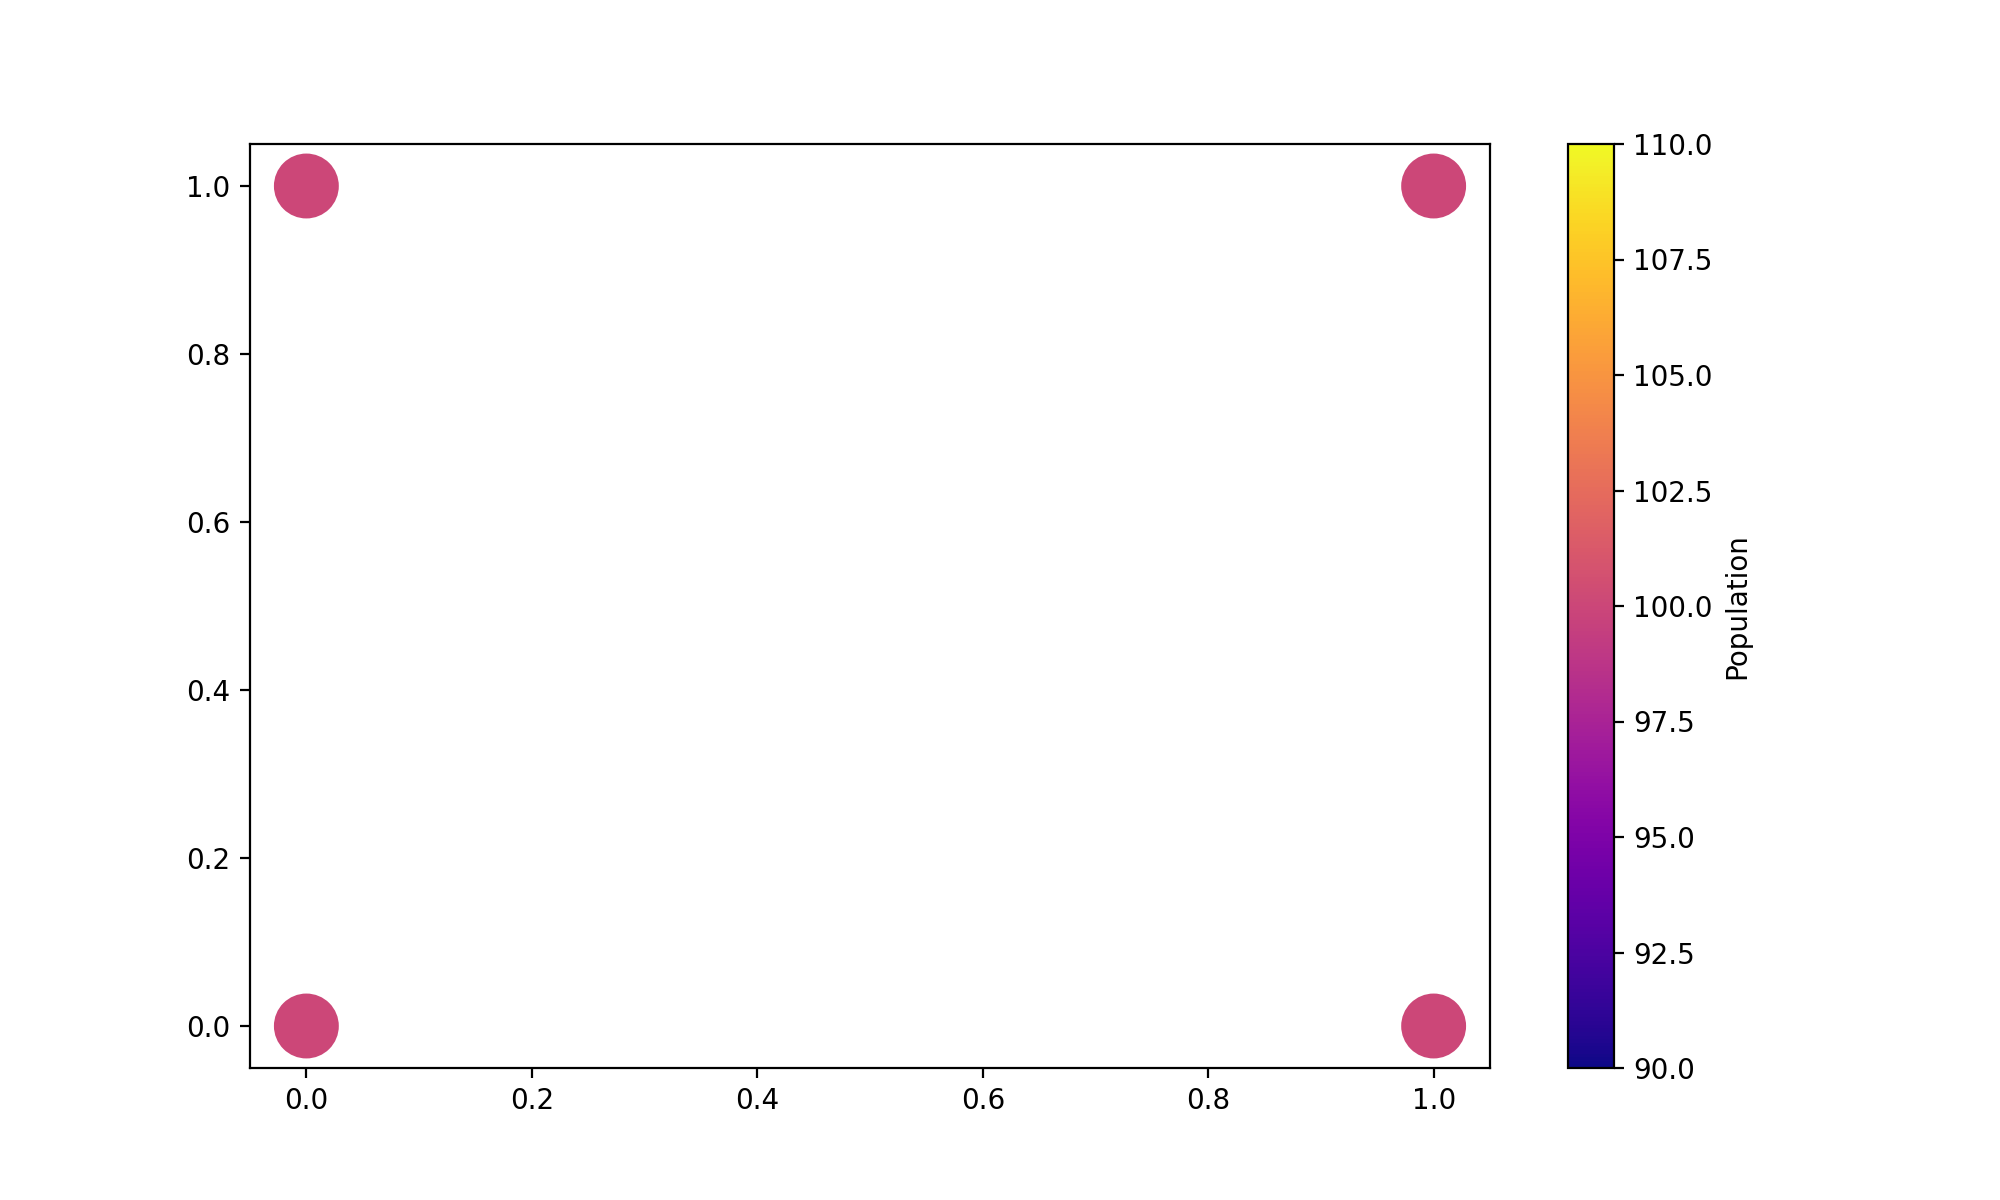

In [730]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np
import numba


n = 5

# Générer des coordonnées x et y aléatoires dans l'intervalle [0, 1]
xp = np.random.rand(n)
yp = np.random.rand(n)

# Générer des poids aléatoires dans l'intervalle [1, 500]
population = np.random.randint(1, 501, size=n)

xp = np.array([0, 1, 0, 1])
yp = np.array([0, 0, 1, 1])
population = np.array([100, 100, 100, 100])
size = population*5


fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(1, 1, 1)
sc = ax.scatter(xp, yp, c=population, cmap='plasma',
                s=size, zorder=3)
plt.colorbar(sc, label='Population')


In [717]:
Hs = 0.2
N = 3
Is = 45
Imin = 1
eps = 1e-1

In [718]:
@numba.jit(nopython = True)
def sigmoid(x, center = 0, M = 100) : 
    return 1/(1+np.exp(-M*(x-center)))

@numba.jit(nopython = True)
def pyth(x1, x2, y1, y2) : 
    return (x2-x1)**2 + (y2-y1)**2

In [719]:
@numba.jit(nopython = True, parallel = True)
def objectif(x) : 
    somme = 0
    for j in numba.prange(len(population)) : 
        sumj = 0
        for i in numba.prange(int(len(x)/2)) : 
            dij_sq = pyth(xp[j], x[2*i], yp[j], x[2*i+1]) + Hs**2
            sumj += Is/(dij_sq) * population[j]
            
        somme += sumj
        
    return -somme

@numba.jit(nopython = True, parallel = True)
def contrainte1(x) : 
    somme = 0
    for j in numba.prange(len(population)) : 
        sumj = 0
        for i in numba.prange(N) : 
            dij_sq = pyth(xp[j], x[2*i], yp[j], x[2*i+1]) + Hs**2
            sumj += Is/(dij_sq)
            
        somme += sigmoid(sumj/population[j], center = Imin, M = 1e2)*population[j]
    return somme/sum(population)


In [726]:
from scipy.optimize import minimize
import numba
from scipy.optimize import NonlinearConstraint
import time
import numpy as np

myc = NonlinearConstraint(contrainte1, 0.9999999, 1)
contraintes = [myc]
x0 = [0] * 2*N
t0 = time.time()
resultat = minimize(objectif, x0, method='COBYLA', constraints = contraintes)
print(time.time()-t0)
print(resultat)
print("Résultat de l'optimisation:", resultat.fun)
print("Valeurs optimales des variables:", resultat.x)
print("Valeur de la contrainte : ", contrainte1(resultat.x))

0.055319786071777344
 message: Maximum number of function evaluations has been exceeded.
 success: False
  status: 2
     fun: -282386.90094339696
       x: [ 1.900e-03  3.793e-03  1.101e-03  1.041e-03  6.049e-01
            3.347e-01]
    nfev: 1000
   maxcv: 0.0
Résultat de l'optimisation: -282386.90094339696
Valeurs optimales des variables: [0.0019004  0.00379332 0.00110094 0.00104098 0.60492128 0.33467879]
Valeur de la contrainte :  0.9999999007098627


<IPython.core.display.Javascript object>


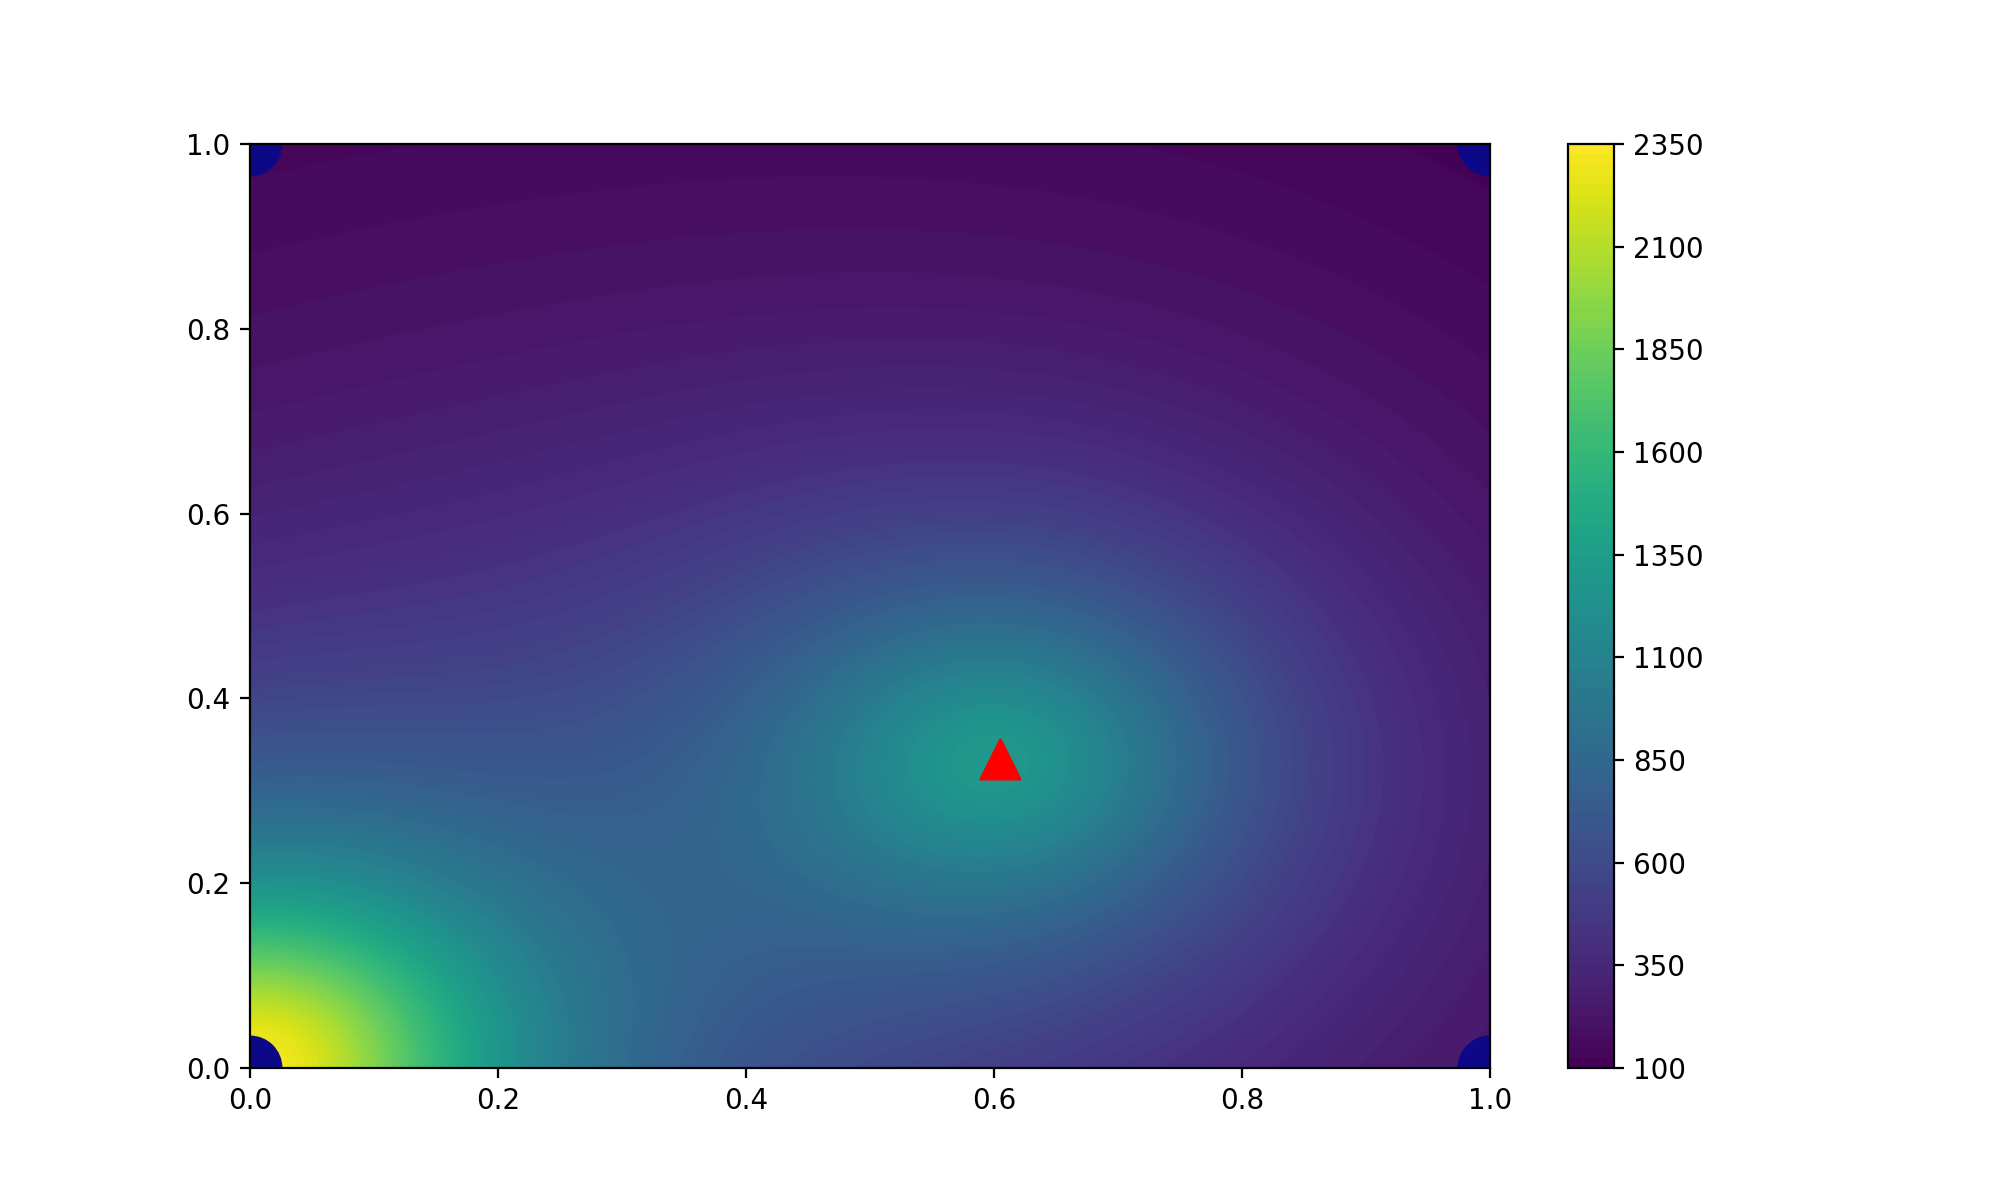

In [729]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(1, 1, 1)

def f(x, y, sol):
    somme = 0
    for i in numba.prange(N) : 
        dij_sq = pyth(x, sol[2*i], y, sol[2*i+1]) + Hs**2
        somme += Is/(dij_sq) 
    return somme

# Générer des points dans le domaine [0, 1] x [0, 1]
x = np.linspace(0, 1, 100)
y = np.linspace(0, 1, 100)
X, Y = np.meshgrid(x, y)

# Calculer les valeurs de la fonction f(x, y) pour chaque point
Z = f(X, Y, resultat.x)


cf = ax.contourf(X, Y, Z, levels=100, cmap='viridis')
plt.colorbar(cf, ax = ax)
for i in range(N) : 
    ax.scatter(resultat.x[2*i], resultat.x[2*i+1], marker = "^", color = "red", s = 200, label = "sattelites")
ax.scatter(xp, yp, c=population, cmap='plasma', s=size)



